In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from qcodes import ManualParameter, Parameter
# %matplotlib inline

In [2]:
from quantify.measurement import MeasurementControl
from quantify.measurement.control import Settable, Gettable
import quantify.visualization.pyqt_plotmon as pqm
from quantify.visualization.instrument_monitor import InstrumentMonitor

In [3]:
# We recommend to always set the directory at the start of the python kernel
# and stick to a single common data directory for all
# notebooks/experiments within your measurement setup/PC

In [4]:
# This sets a default data directory for tutorial purposes. Change it to your desired data directory.
from pathlib import Path
from os.path import join
from quantify.data.handling import get_datadir, set_datadir
set_datadir(join(Path.home(), 'quantify-data')) # change me!
print(f"Data will be saved in:\n{get_datadir()}")

Data will be saved in:
/Users/adriaanrol/quantify-data


In [5]:
MC = MeasurementControl('MC')
# Create the live plotting intrument which handles the graphical interface
# Two windows will be created, the main will feature 1D plots and any 2D plots will go to the secondary
plotmon = pqm.PlotMonitor_pyqt('plotmon')
# Connect the live plotting monitor to the measurement control
MC.instr_plotmon(plotmon.name)

# The instrument monitor will give an overview of all parameters of all instruments
insmon = InstrumentMonitor("Instruments Monitor")
# By connecting to the MC the parameters will be updated in real-time during an experiment.
MC.instrument_monitor(insmon.name)

In [6]:
from time import sleep

# We create an instrument to contain all the parameters of our model to ensure we have proper data logging.
from qcodes.instrument import Instrument

pars = Instrument('ParameterHolder')

# ManualParameter's is a handy class that preserves the QCoDeS' Parameter
# structure without necessarily having a connection to the physical world
pars.add_parameter('amp', initial_value=1, unit='V', label='Amplitude', parameter_class=ManualParameter)
pars.add_parameter('freq', initial_value=.5, unit='Hz', label='Frequency', parameter_class=ManualParameter)
pars.add_parameter('t', initial_value=1, unit='s', label='Time', parameter_class=ManualParameter)
pars.add_parameter('phi', initial_value=0, unit='Rad', label='Phase', parameter_class=ManualParameter)
pars.add_parameter('noise_level', initial_value=0.05, unit='V', label='Noise level', parameter_class=ManualParameter)
pars.add_parameter('acq_delay', initial_value=.1, unit='s', parameter_class=ManualParameter)

def cos_func(t, amplitude, frequency, phase, offset):
    """A simple cosine function"""
    return amplitude * np.cos(2 * np.pi * frequency * t + phase) + offset

def cosine_model():
    sleep(pars.acq_delay()) # simulates the acquisition delay of an instrument
    return cos_func(pars.t(), pars.amp(), pars.freq(), phase=pars.phi(), offset=0) + np.random.randn() * pars.noise_level()

# We wrap our function in a Parameter to be able to associate metadata to it, e.g. units
sig = pars.add_parameter(name='sig', label='Signal level', unit='V', get_cmd=cosine_model)

In [8]:
# by setting this to a non-zero value we can see the live plotting in action for a slower experiment
pars.acq_delay(0.1)

In [9]:
MC.settables(pars.t)                     # as a QCoDeS parameter, 't' obeys the JSON schema for a valid Settable and can be passed to the MC directly.
MC.setpoints(np.linspace(0, 5, 50))
MC.gettables(pars.sig)                   # as a QCoDeS parameter, 'sig' obeys the JSON schema for a valid Gettable and can be passed to the MC directly.
dset = MC.run('Cosine test')

Starting iterative measurement...
100% completed  elapsed time:      5s  time left:      0s  
100% completed  elapsed time:      5s  time left:      0s  

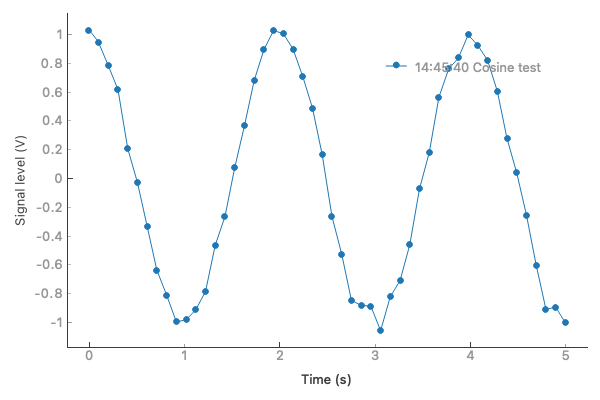

In [10]:
plotmon.main_QtPlot

In [11]:
# The dataset has a time-based unique identifier automatically assigned to it
# The name of the experiment is stored as well
dset.attrs['tuid'], dset.attrs['name']

('20210413-144540-507-4b2cd1', 'Cosine test')

In [12]:
dset

<xarray.Dataset>
Dimensions:  (dim_0: 50)
Coordinates:
    x0       (dim_0) float64 0.0 0.102 0.2041 0.3061 ... 4.694 4.796 4.898 5.0
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 1.031 0.9464 0.7853 ... -0.9091 -0.8932 -1.003
Attributes:
    tuid:     20210413-144540-507-4b2cd1
    name:     Cosine test
    2D-grid:  False

In [13]:
# By default the MC updates the datafile and live plot every 0.1 seconds (and not faster) to reduce overhead.
MC.update_interval(0.1) # Setting it even to 0.01 creates a dramatic slowdown, try it out!

In [14]:
pars.acq_delay(.01)

In [21]:
pars.amp(.01)

In [22]:
MC.settables(pars.t)
MC.setpoints(np.linspace(0, 50, 1000))
MC.gettables(pars.sig)
dset = MC.run('Many points live plot test')

Starting iterative measurement...
100% completed  elapsed time:     16s  time left:      0s  
100% completed  elapsed time:     16s  time left:      0s  

In [23]:
a=Basic1DAnalysis()

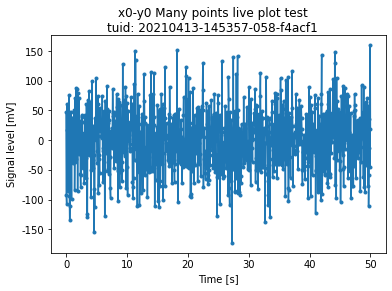

In [24]:
a.display_figs_mpl()

In [16]:
dset

<xarray.Dataset>
Dimensions:  (dim_0: 1000)
Coordinates:
    x0       (dim_0) float64 0.0 0.05005 0.1001 0.1502 ... 49.85 49.9 49.95 50.0
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 1.051 1.036 0.8454 0.8745 ... 1.045 0.9794 1.032
Attributes:
    tuid:     20210413-144607-627-f72af8
    name:     Many points live plot test
    2D-grid:  False

In [17]:
from quantify.analysis.base_analysis import Basic1DAnalysis

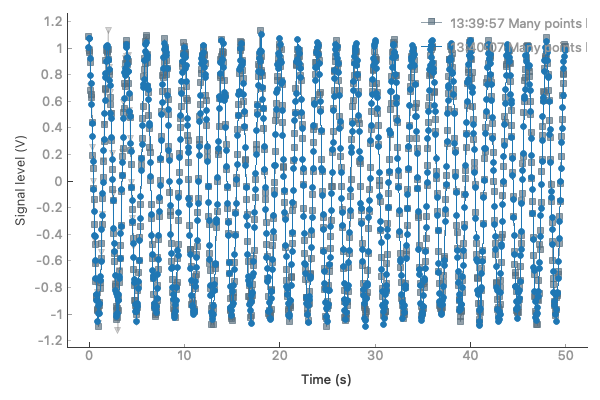

In [16]:
plotmon.main_QtPlot

In [17]:
pars.noise_level(0) #let's disable noise from here on to get prettier figures

In [18]:
from quantify.data.handling import load_dataset, get_latest_tuid

# here we look for the latest datafile in the datadirectory named "Cosine test"
# note that this is not he last dataset but one dataset earlier
tuid = get_latest_tuid('Cosine test')
print('tuid: {}'.format(tuid))
dset = load_dataset(tuid)

dset

tuid: 20210409-133935-202-9b2a4d


<xarray.Dataset>
Dimensions:  (dim_0: 50)
Coordinates:
    x0       (dim_0) float64 0.0 0.102 0.2041 0.3061 ... 4.694 4.796 4.898 5.0
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 0.9563 0.9894 0.712 ... -0.795 -0.9248 -1.066
Attributes:
    2D-grid:  False
    name:     Cosine test
    tuid:     20210409-133935-202-9b2a4d

<AxesSubplot:title={'center':'Model(cos_func)'}, xlabel='t', ylabel='y'>

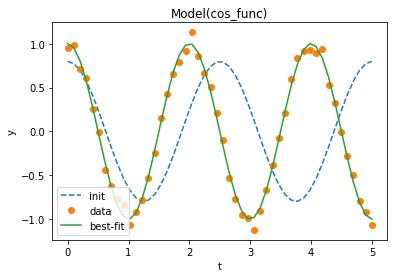

In [19]:
import lmfit
# we create a model based on our function
mod = lmfit.Model(cos_func)
# and specify initial guesses for each parameter
mod.set_param_hint('amplitude', value=.8, vary=True)
mod.set_param_hint('frequency', value=.4)
mod.set_param_hint('phase', value=0, vary=False)
mod.set_param_hint('offset', value=0, vary=False)
params = mod.make_params()
# and here we perform the fit.
fit_res = mod.fit(dset['y0'].values, t=dset['x0'].values, params=params)

# It is possible to get a quick visualization of our fit using a build-in method of lmfit
fit_res.plot_fit(show_init=True)

In [20]:
fit_res.params

name,value,standard error,relative error,initial value,min,max,vary
amplitude,1.00371786,0.01238260,(1.23%),0.8,-inf,inf,True
frequency,0.50031708,6.9686e-04,(0.14%),0.4,-inf,inf,True
phase,0.00000000,0.00000000,,0,-inf,inf,False
offset,0.00000000,0.00000000,,0,-inf,inf,False


In [21]:
# And we can print an overview of the fitting results
print(fit_res.fit_report())

[[Model]]
    Model(cos_func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 50
    # variables        = 2
    chi-square         = 0.18727790
    reduced chi-square = 0.00390162
    Akaike info crit   = -275.359234
    Bayesian info crit = -271.535188
[[Variables]]
    amplitude:  1.00371786 +/- 0.01238260 (1.23%) (init = 0.8)
    frequency:  0.50031708 +/- 6.9686e-04 (0.14%) (init = 0.4)
    phase:      0 (fixed)
    offset:     0 (fixed)


In [22]:
# We include some visualization utilities in quantify
from quantify.visualization.SI_utilities import set_xlabel, set_ylabel

Text(0.5, 1.0, '20210409-133935-202-9b2a4d\nCosine test')

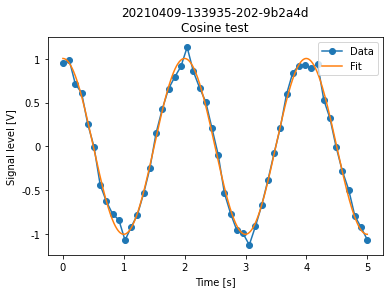

In [23]:
f, ax = plt.subplots()

ax.plot(dset['x0'], dset['y0'], marker='o', label='Data')
x_fit = np.linspace(dset['x0'][0], dset['x0'][-1], 1000)
y_fit = cos_func(t=x_fit, **fit_res.best_values)
ax.plot(x_fit, y_fit, label='Fit')
ax.legend()

set_xlabel(ax, dset['x0'].attrs['long_name'], dset['x0'].attrs['units'])
set_ylabel(ax, dset['y0'].attrs['long_name'], dset['y0'].attrs['units'])
ax.set_title('{}\n{}'.format(tuid, 'Cosine test'))

In [22]:
from quantify.data.handling import locate_experiment_container
# Here we are using this function as a convenient way of retrieving the experiment
# folder without using an absolute path
exp_folder = locate_experiment_container(dset.tuid)

In [23]:
from os.path import join
# Save fit results
lmfit.model.save_modelresult(fit_res, join(exp_folder, 'fit_res.json'))
# Save figure
f.savefig(join(exp_folder, 'Cosine fit.png'), dpi=300, bbox_inches='tight')

In [24]:
pars.acq_delay(0.0001)
MC.update_interval(2.0)

In [25]:
times = np.linspace(0, 5, 500)
amps = np.linspace(-1, 1, 31)

MC.settables([pars.t, pars.amp])
# MC takes care of creating a meshgrid
MC.setpoints_grid([times, amps])
MC.gettables(pars.sig)
dset = MC.run('2D Cosine test')

Starting iterative measurement...
100% completed  elapsed time:      5s  time left:      0s  
100% completed  elapsed time:      5s  time left:      0s  

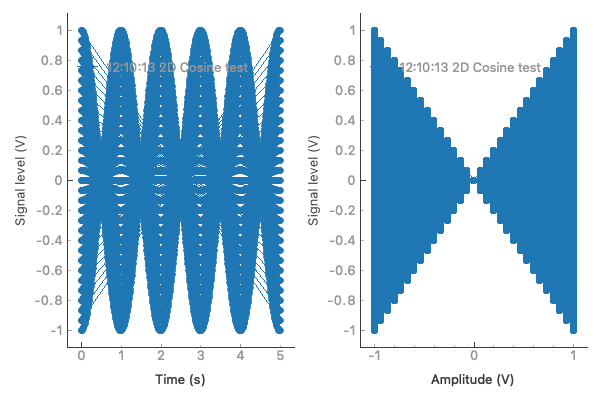

In [26]:
plotmon.main_QtPlot

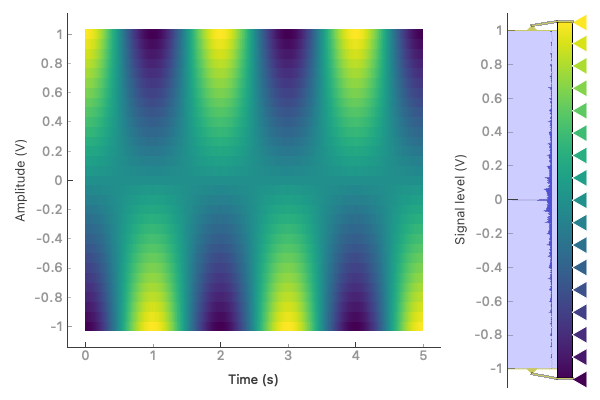

In [27]:
plotmon.secondary_QtPlot

In [28]:
r = np.linspace(0, 1.5, 2000)
dt = np.linspace(0, 1, 2000)

f = 10

theta = np.cos(2*np.pi*f*dt)
def polar_coords(r, theta):

    x = r*np.cos(2*np.pi*theta)
    y = r*np.sin(2*np.pi*theta)
    return x, y

x, y = polar_coords(r, theta)
setpoints = np.column_stack([x, y])
setpoints

array([[ 0.00000000e+00, -0.00000000e+00],
       [ 7.50371574e-04, -2.32876698e-06],
       [ 1.50063480e-03, -1.86250865e-05],
       ...,
       [ 1.49838385e+00, -1.85971489e-02],
       [ 1.49924240e+00, -4.65287642e-03],
       [ 1.50000000e+00, -3.67394040e-16]])

In [29]:
pars.acq_delay(0.0001)
MC.update_interval(2.0)

In [30]:
MC.settables([pars.t, pars.amp])
MC.setpoints(setpoints)
MC.gettables(pars.sig)
dset = MC.run('2D radial setpoints')

Starting iterative measurement...
100% completed  elapsed time:      0s  time left:      0s  
100% completed  elapsed time:      0s  time left:      0s  

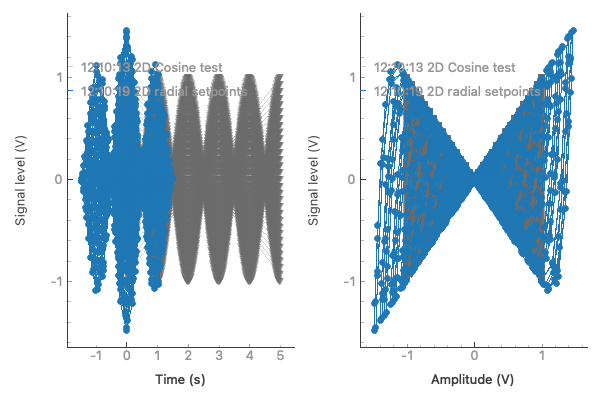

In [31]:
plotmon.main_QtPlot

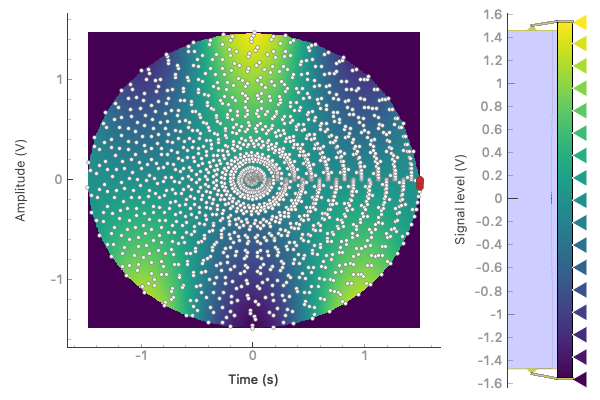

In [32]:
plotmon.secondary_QtPlot